## Data loading

### Subtask:
Load the provided CSV files into pandas DataFrames.


**Reasoning**:
Load the two CSV files into pandas DataFrames and display the first 5 rows of each to verify.



In [3]:
import pandas as pd


df_train = pd.read_csv('../../Data/original/train_2025.csv')
df_test = pd.read_csv('../../Data/original/test_2025.csv') 
display(df_test.head())
display(df_train.head())

,claim_number,age_of_driver,gender,marital_status,safty_rating,annual_income,high_education_ind,address_change_ind,living_status,zip_code,...,liab_prct,channel,policy_report_filed_ind,claim_est_payout,age_of_vehicle,vehicle_category,vehicle_price,vehicle_color,vehicle_weight,fraud
0,2309,38,M,1.0,87,56489,1,1,Own,15012,...,64,Broker,0,4117.36,1,Compact,15000.000000,gray,37431.770860,NaN
1,22405,43,M,1.0,97,112438,0,0,Own,85077,...,81,Broker,1,3448.53,8,Medium,15000.000000,other,9798.499787,NaN
2,23398,49,M,1.0,75,62518,1,0,Own,20132,...,94,Broker,1,0.00,1,Compact,62864.328069,gray,15044.245540,NaN
3,25059,55,M,1.0,70,96372,1,1,Rent,85067,...,47,Broker,0,2250.25,14,Large,15000.000000,red,6167.761870,NaN
4,2665,22,M,1.0,88,85049,0,1,Rent,85071,...,93,Online,1,5714.93,1,Medium,15000.000000,other,19802.270180,NaN


,claim_number,age_of_driver,gender,marital_status,safty_rating,annual_income,high_education_ind,address_change_ind,living_status,zip_code,...,liab_prct,channel,policy_report_filed_ind,claim_est_payout,age_of_vehicle,vehicle_category,vehicle_price,vehicle_color,vehicle_weight,fraud
0,2759,58,M,1.0,83,117115,1,0,Own,85027,...,88,Broker,0,0.00,4,Medium,55066.875563,other,21515.14956,0
1,11338,37,F,0.0,76,57945,1,0,Rent,85004,...,2,Broker,1,0.00,1,Large,29937.566096,blue,22570.44842,0
2,23150,33,F,0.0,82,79027,1,0,Rent,85027,...,95,Broker,1,0.00,1,Compact,15000.000000,black,10701.08860,0
3,19040,43,F,0.0,40,98544,1,0,Own,15028,...,100,Broker,0,850.63,1,Large,92867.354408,white,21434.93439,1
4,10803,43,F,1.0,84,62619,1,1,Own,20148,...,58,Broker,0,3375.85,1,Medium,74071.734863,blue,48036.29694,0


## Data exploration

Explore the loaded datasets to understand their basic characteristics.


In [8]:
print("df_test shape:", df_test.shape)
print("\ndf_test data types:\n", df_test.dtypes)
print("\ndf_test descriptive statistics:\n", df_test.describe())
print("\ndf_test missing values:\n", df_test.isnull().sum())

df_test shape: (12000, 25)

df_test data types:
 claim_number                 int64
age_of_driver                int64
gender                      object
marital_status             float64
safty_rating                 int64
annual_income                int64
high_education_ind           int64
address_change_ind           int64
living_status               object
zip_code                     int64
claim_date                  object
claim_day_of_week           object
accident_site               object
past_num_of_claims           int64
witness_present_ind        float64
liab_prct                    int64
channel                     object
policy_report_filed_ind      int64
claim_est_payout           float64
age_of_vehicle               int64
vehicle_category            object
vehicle_price              float64
vehicle_color               object
vehicle_weight             float64
fraud                      float64
dtype: object

df_test descriptive statistics:
        claim_number  age_of_

In [9]:
print("df_train shape:", df_train.shape)
print("\ndf_train data types:\n", df_train.dtypes)
print("\ndf_train descriptive statistics:\n", df_train.describe())
print("\ndf_train missing values:\n", df_train.isnull().sum())

df_train shape: (18000, 25)

df_train data types:
 claim_number                 int64
age_of_driver                int64
gender                      object
marital_status             float64
safty_rating                 int64
annual_income                int64
high_education_ind           int64
address_change_ind           int64
living_status               object
zip_code                     int64
claim_date                  object
claim_day_of_week           object
accident_site               object
past_num_of_claims           int64
witness_present_ind        float64
liab_prct                    int64
channel                     object
policy_report_filed_ind      int64
claim_est_payout           float64
age_of_vehicle               int64
vehicle_category            object
vehicle_price              float64
vehicle_color               object
vehicle_weight             float64
fraud                        int64
dtype: object

df_train descriptive statistics:
        claim_number  age_

## Data analysis

### Subtask:
Perform more in-depth analysis on the numerical features of both datasets.


**Reasoning**:
Identify outliers, analyze correlations, examine distributions, and analyze the target variable's relationship with numerical features in both datasets.



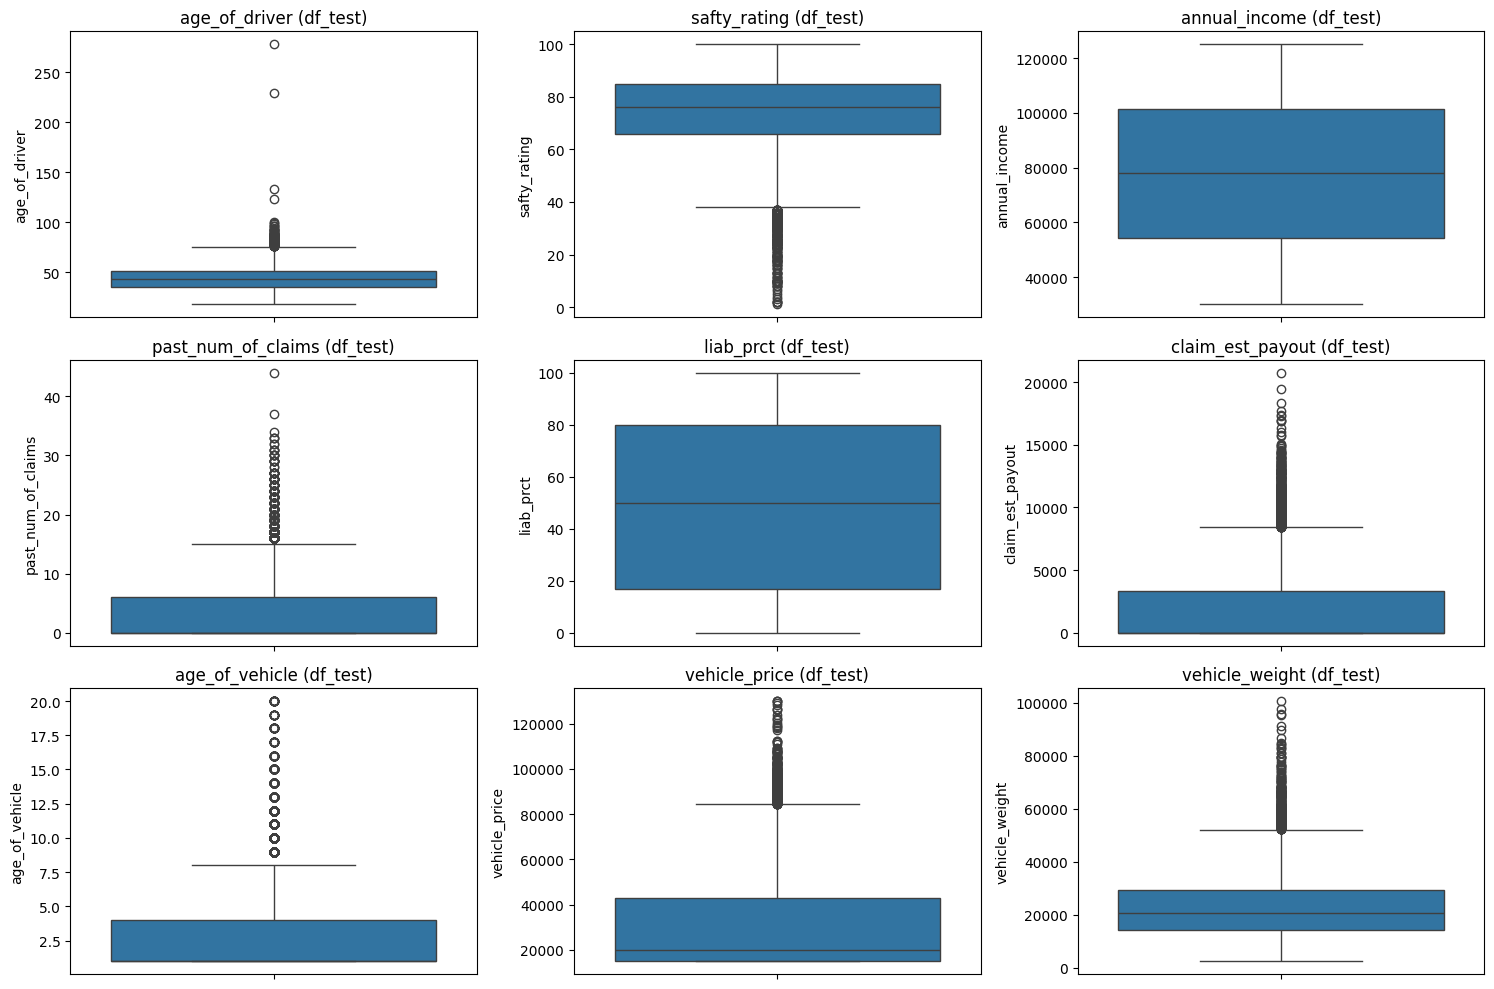

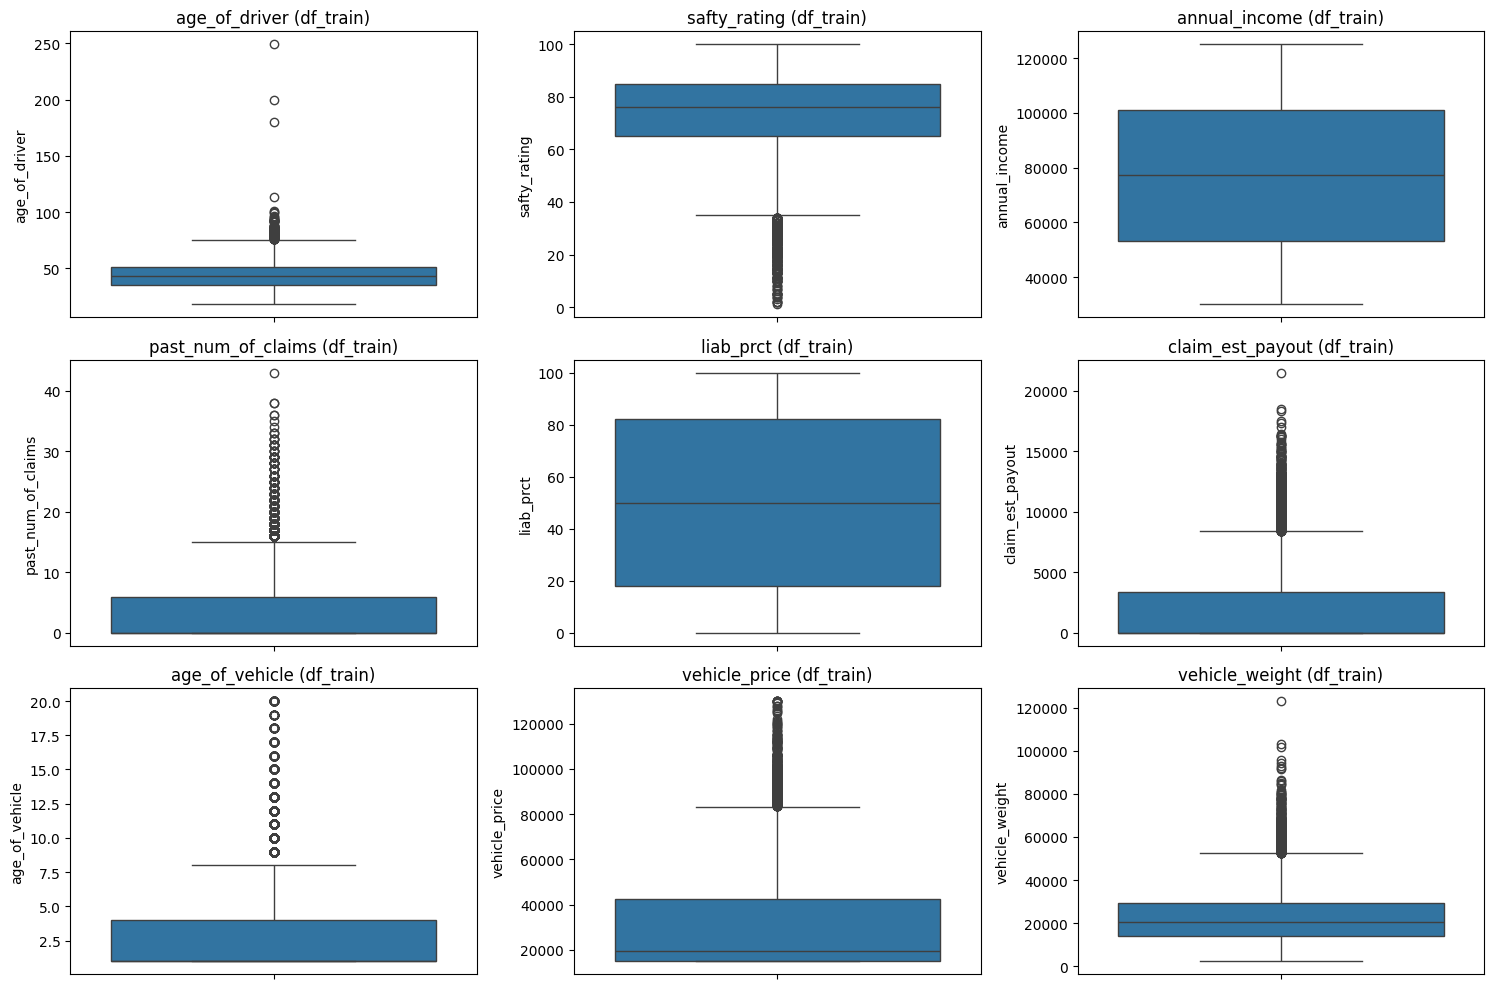

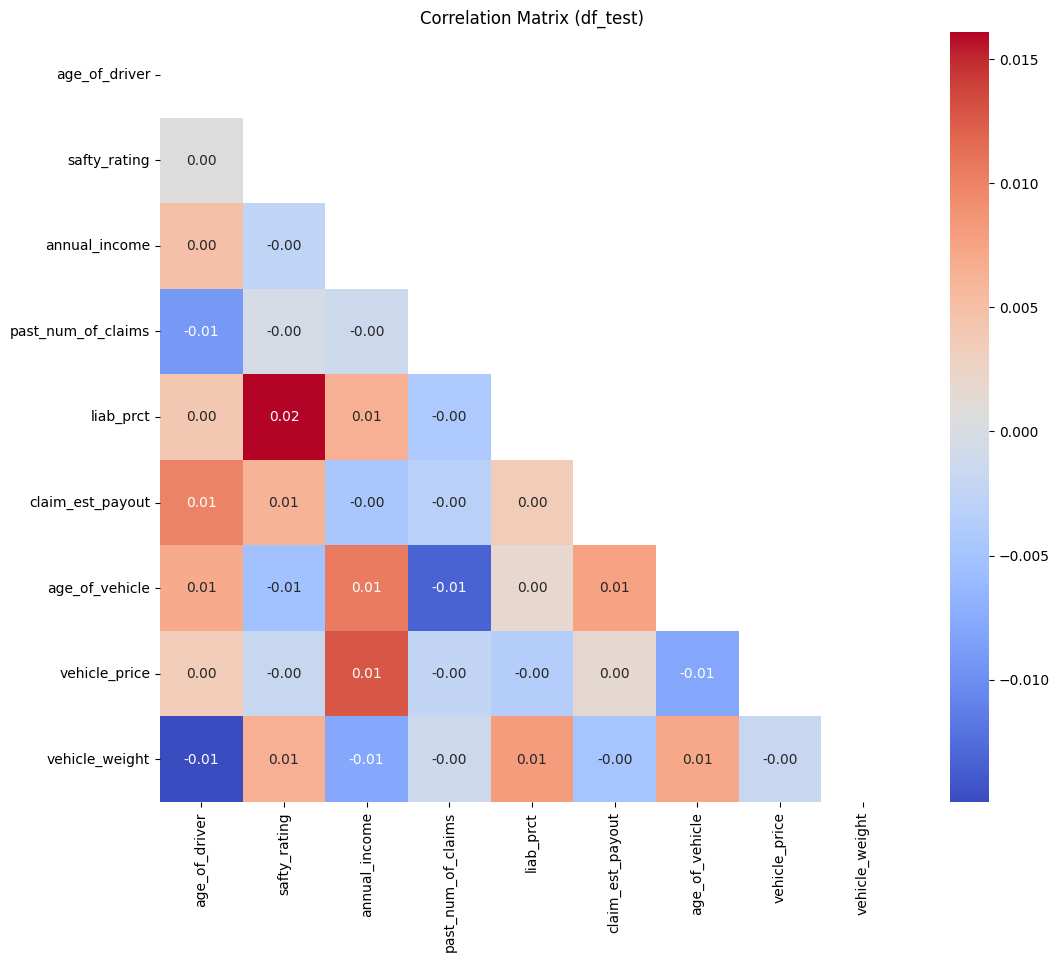

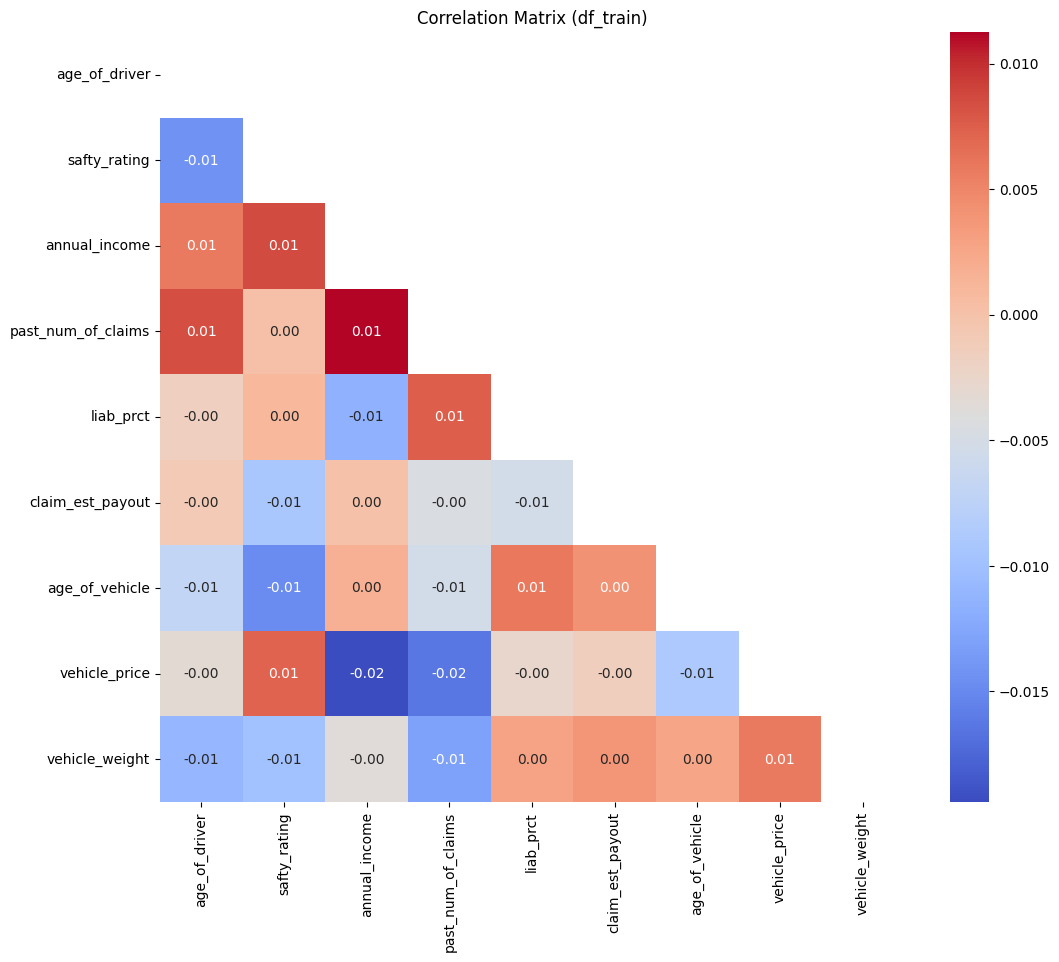

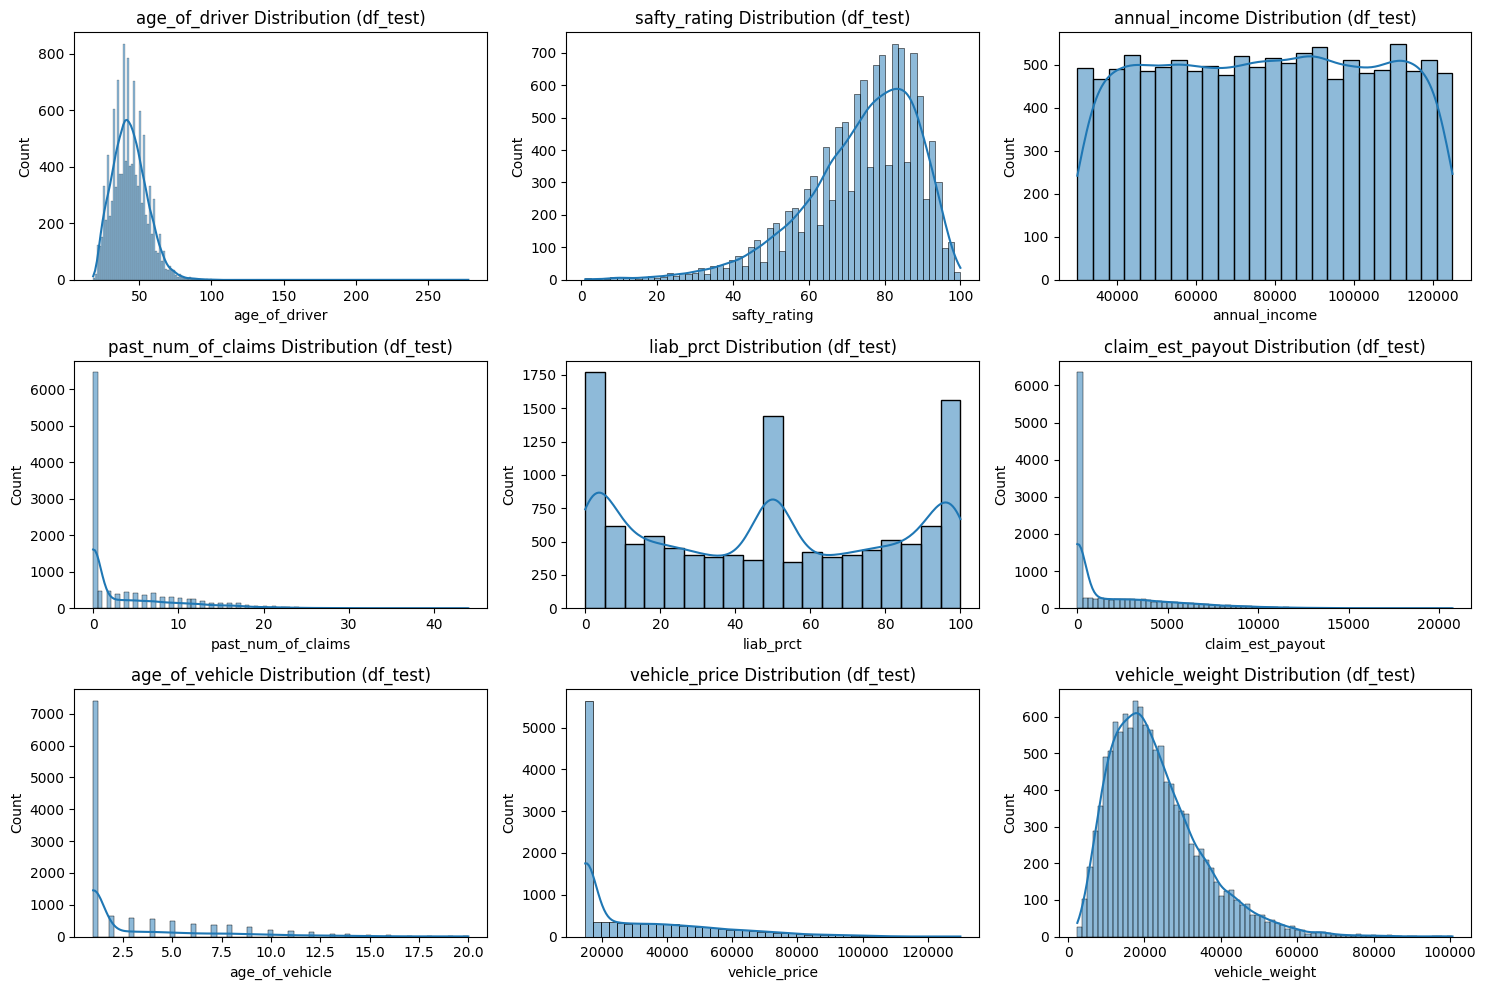

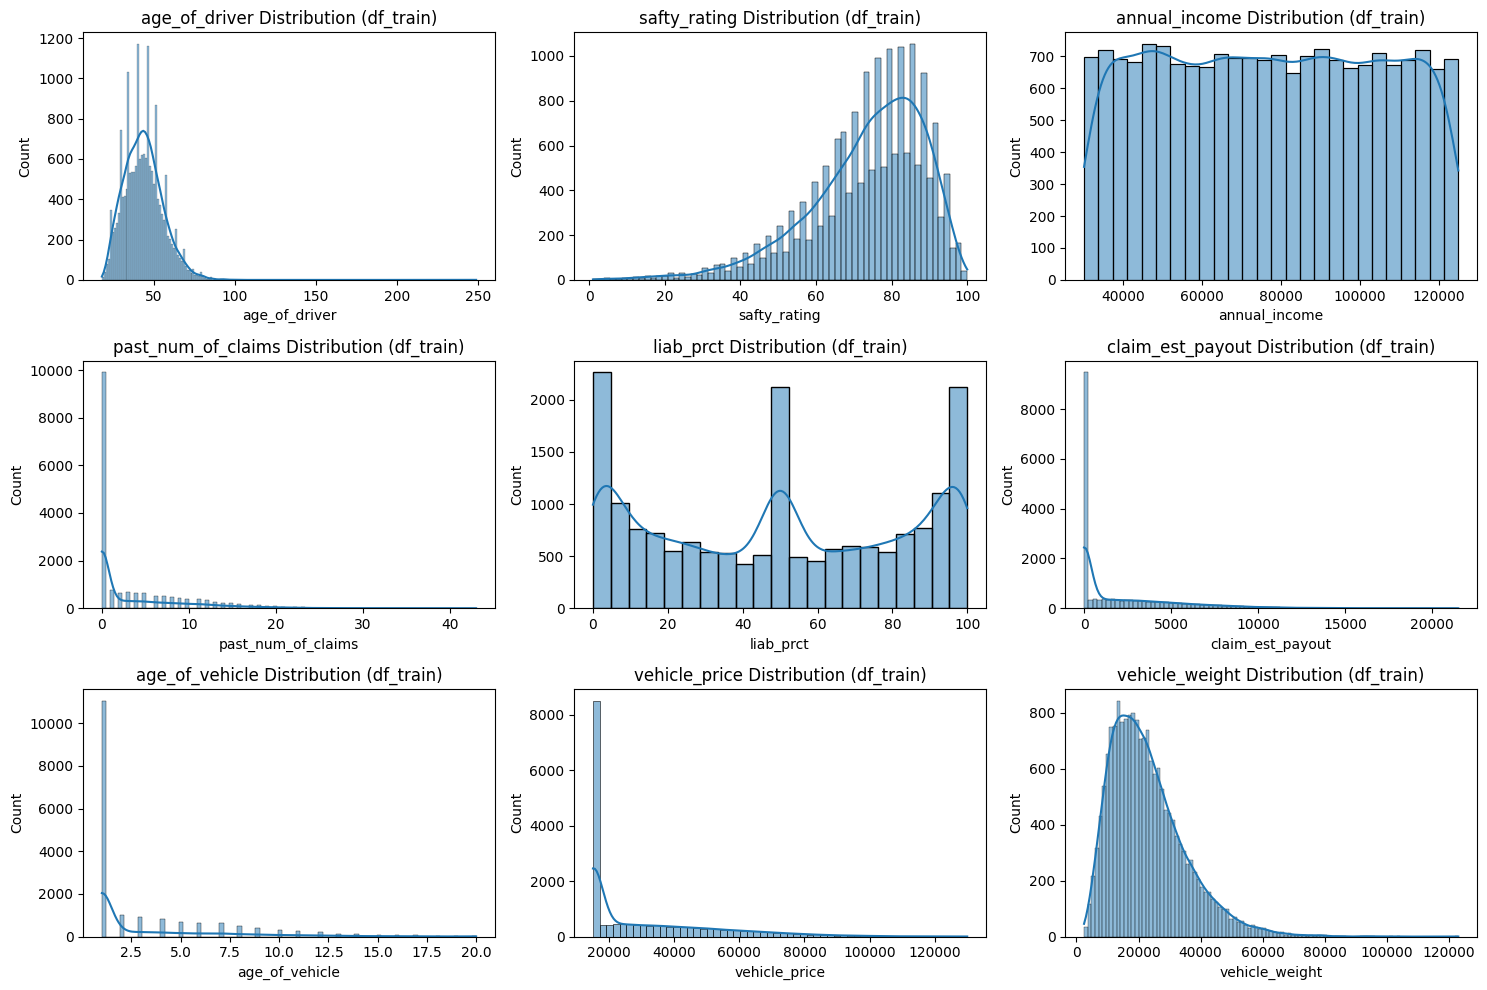

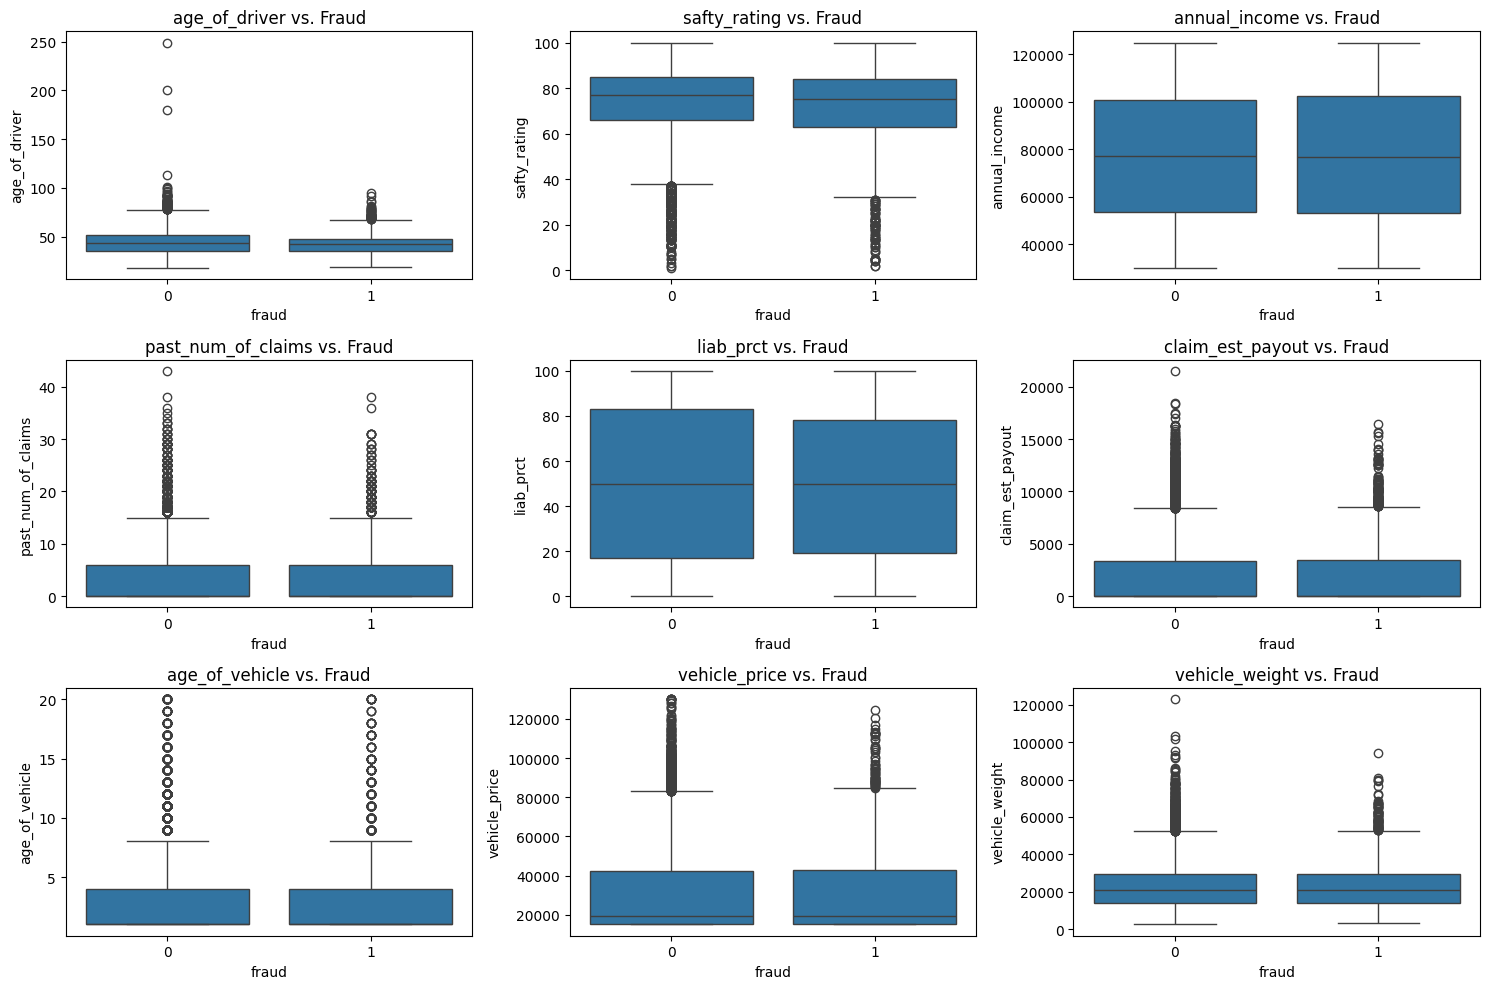

In [12]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Numerical features for analysis
numerical_features = ['age_of_driver', 'safty_rating', 'annual_income', 'past_num_of_claims', 'liab_prct', 'claim_est_payout', 'age_of_vehicle', 'vehicle_price', 'vehicle_weight']

# 1. Outlier Detection
for df_name, df in [('df_test', df_test), ('df_train', df_train)]:
    plt.figure(figsize=(15, 10))
    for i, col in enumerate(numerical_features):
        plt.subplot(3, 3, i + 1)
        sns.boxplot(y=df[col])
        plt.title(f'{col} ({df_name})')
    plt.tight_layout()
    plt.show()

# 2. Correlation Analysis
for df_name, df in [('df_test', df_test), ('df_train', df_train)]:
    plt.figure(figsize=(12, 10))
    corr_matrix = df[numerical_features].corr()
    # Create a mask for the upper triangle including the diagonal
    mask = np.triu(np.ones_like(corr_matrix, dtype=bool))
    sns.heatmap(
        corr_matrix,
        mask=mask,
        annot=True,
        cmap='coolwarm',
        fmt=".2f"
    )
    plt.title(f'Correlation Matrix ({df_name})')
    plt.show()

# 3. Feature Distribution Analysis
for df_name, df in [('df_test', df_test), ('df_train', df_train)]:
    plt.figure(figsize=(15, 10))
    for i, col in enumerate(numerical_features):
        plt.subplot(3, 3, i + 1)
        sns.histplot(df[col], kde=True)
        plt.title(f'{col} Distribution ({df_name})')
    plt.tight_layout()
    plt.show()

# 4. Target Variable Analysis (for df_train only)
plt.figure(figsize=(15, 10))
for i, col in enumerate(numerical_features):
    plt.subplot(3, 3, i + 1)
    sns.boxplot(x='fraud', y=col, data=df_train)
    plt.title(f'{col} vs. Fraud')
plt.tight_layout()
plt.show()

## Data visualization

### Subtask:
Visualize key features of the datasets to gain insights into their distributions and relationships.


**Reasoning**:
Visualize key features of the datasets using histograms, bar charts, box plots, and a correlation heatmap, as instructed.



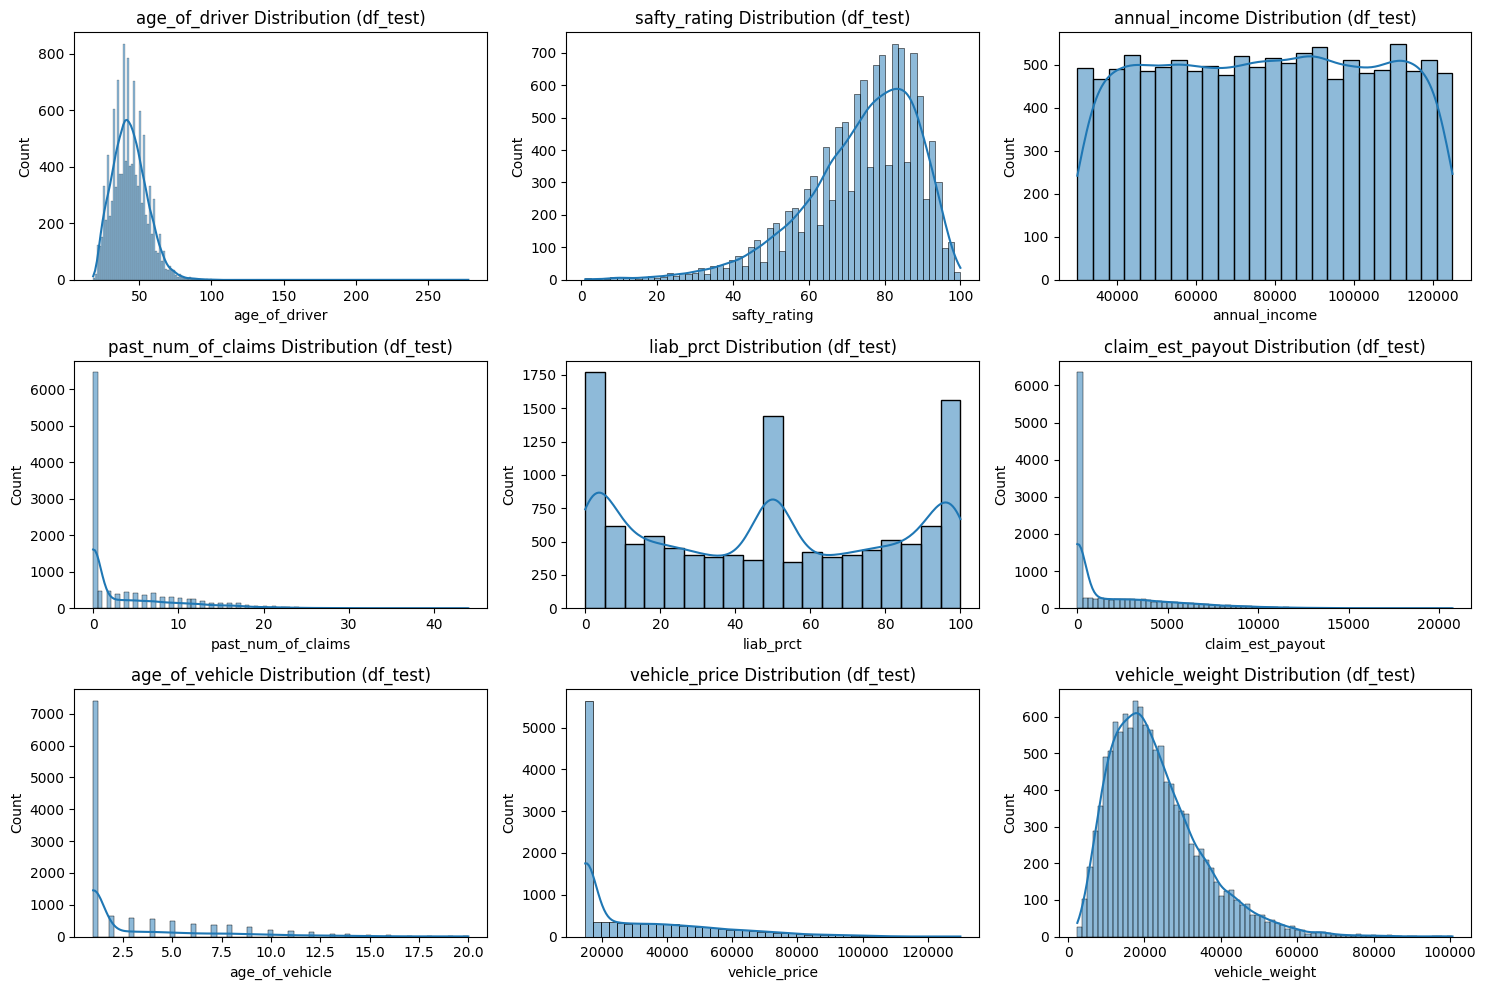

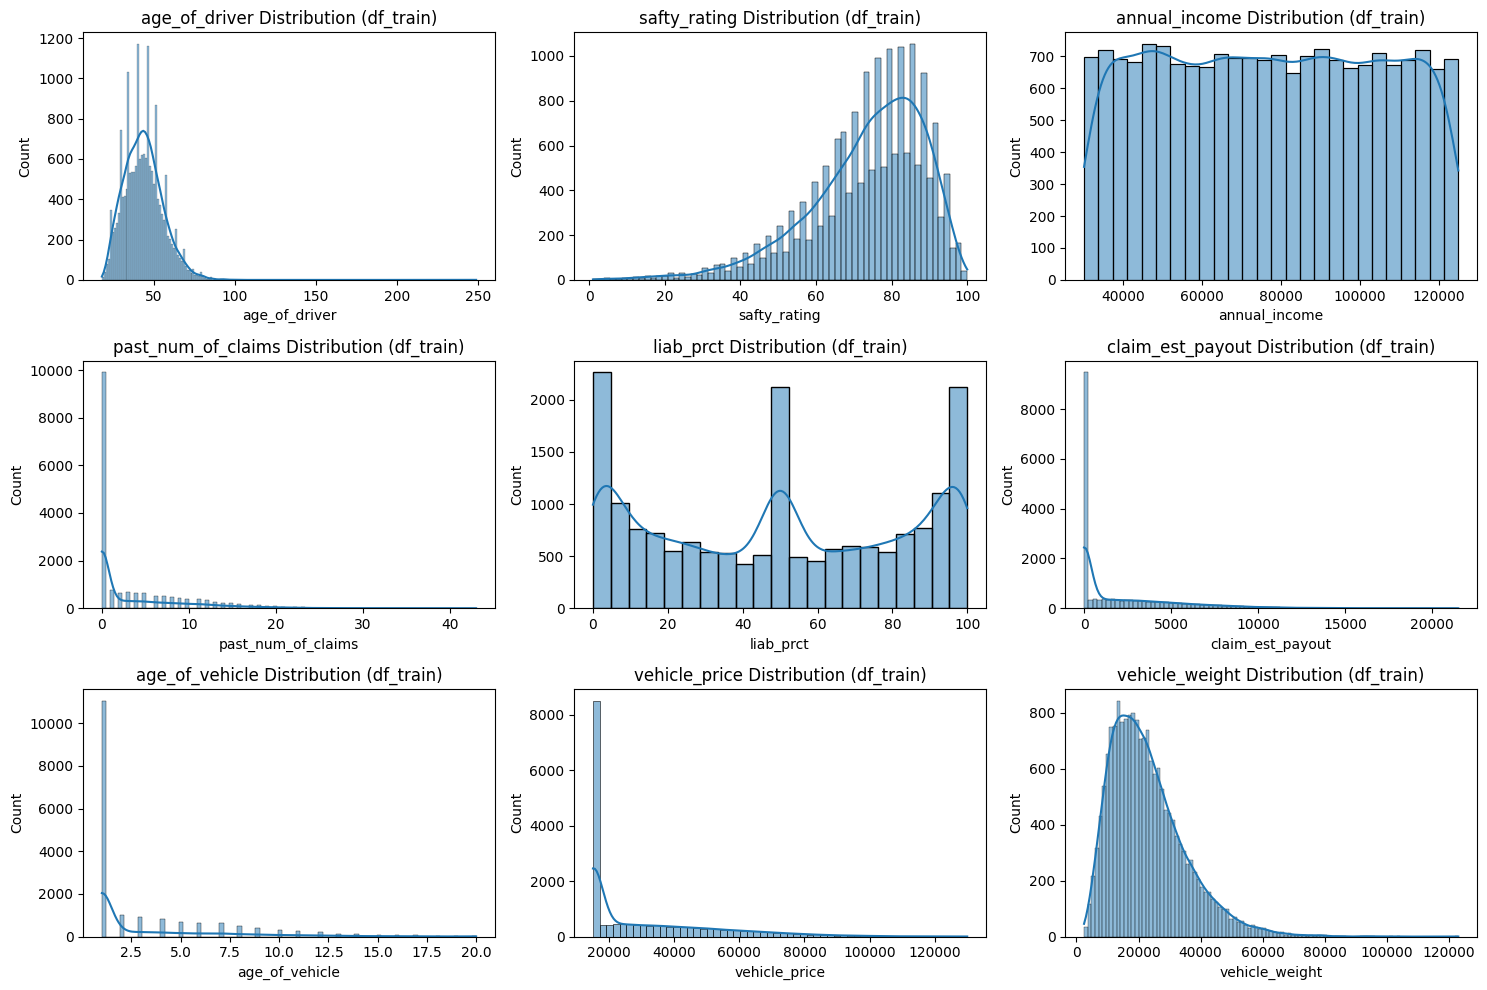

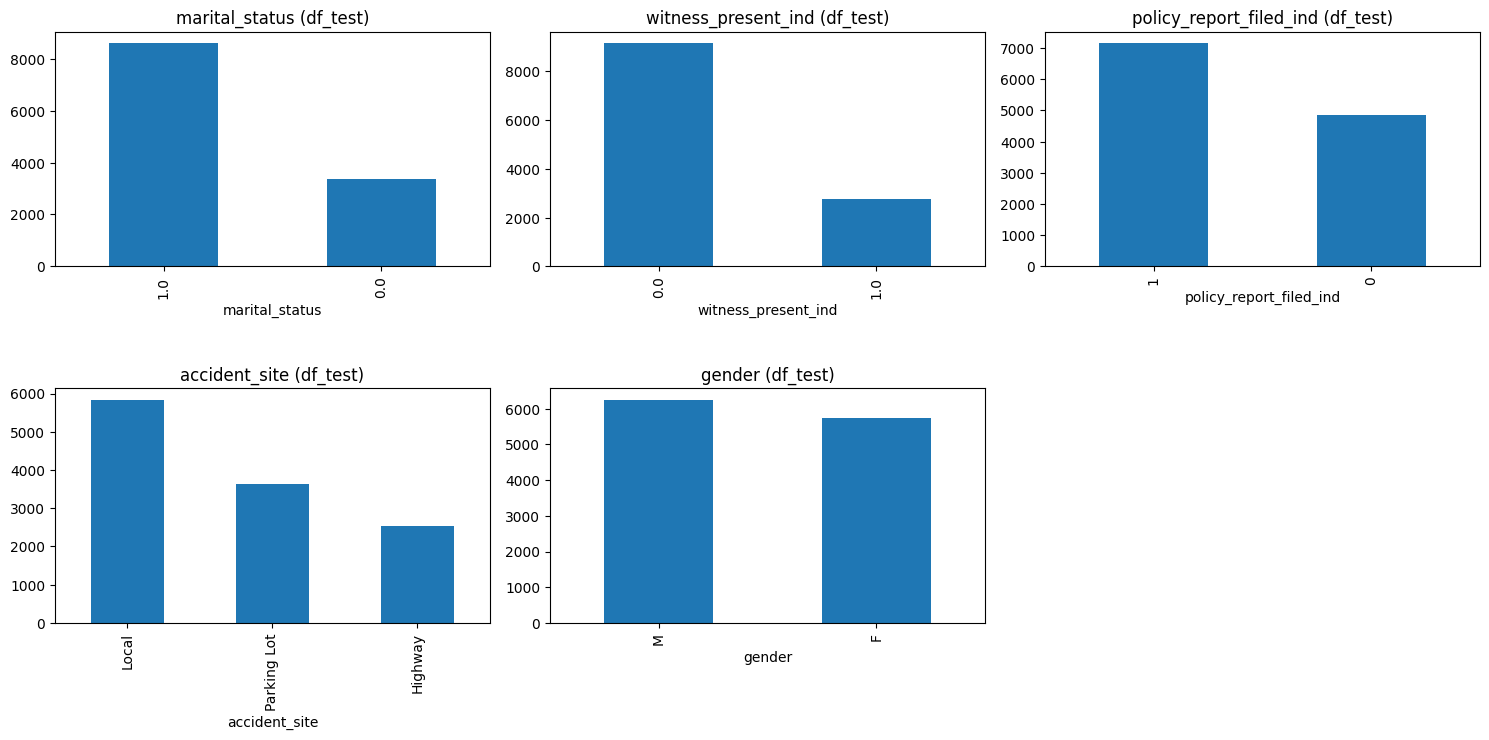

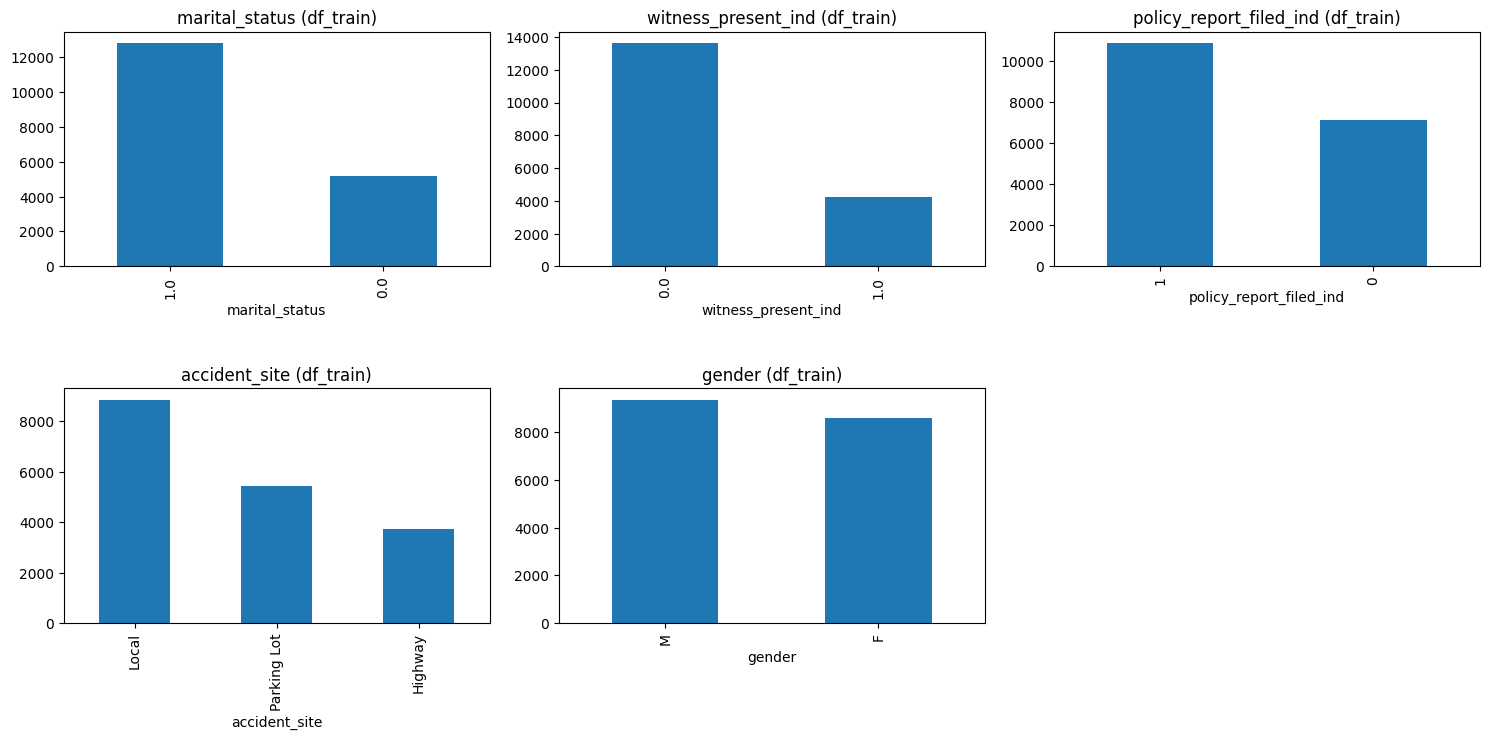

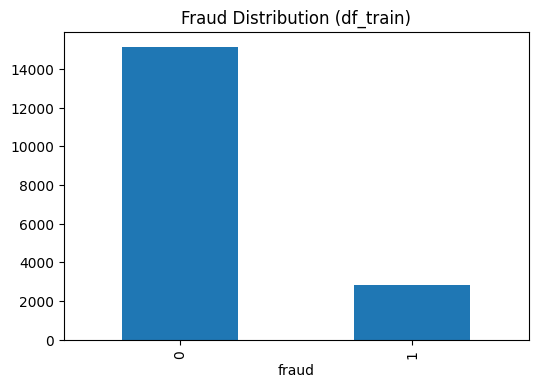

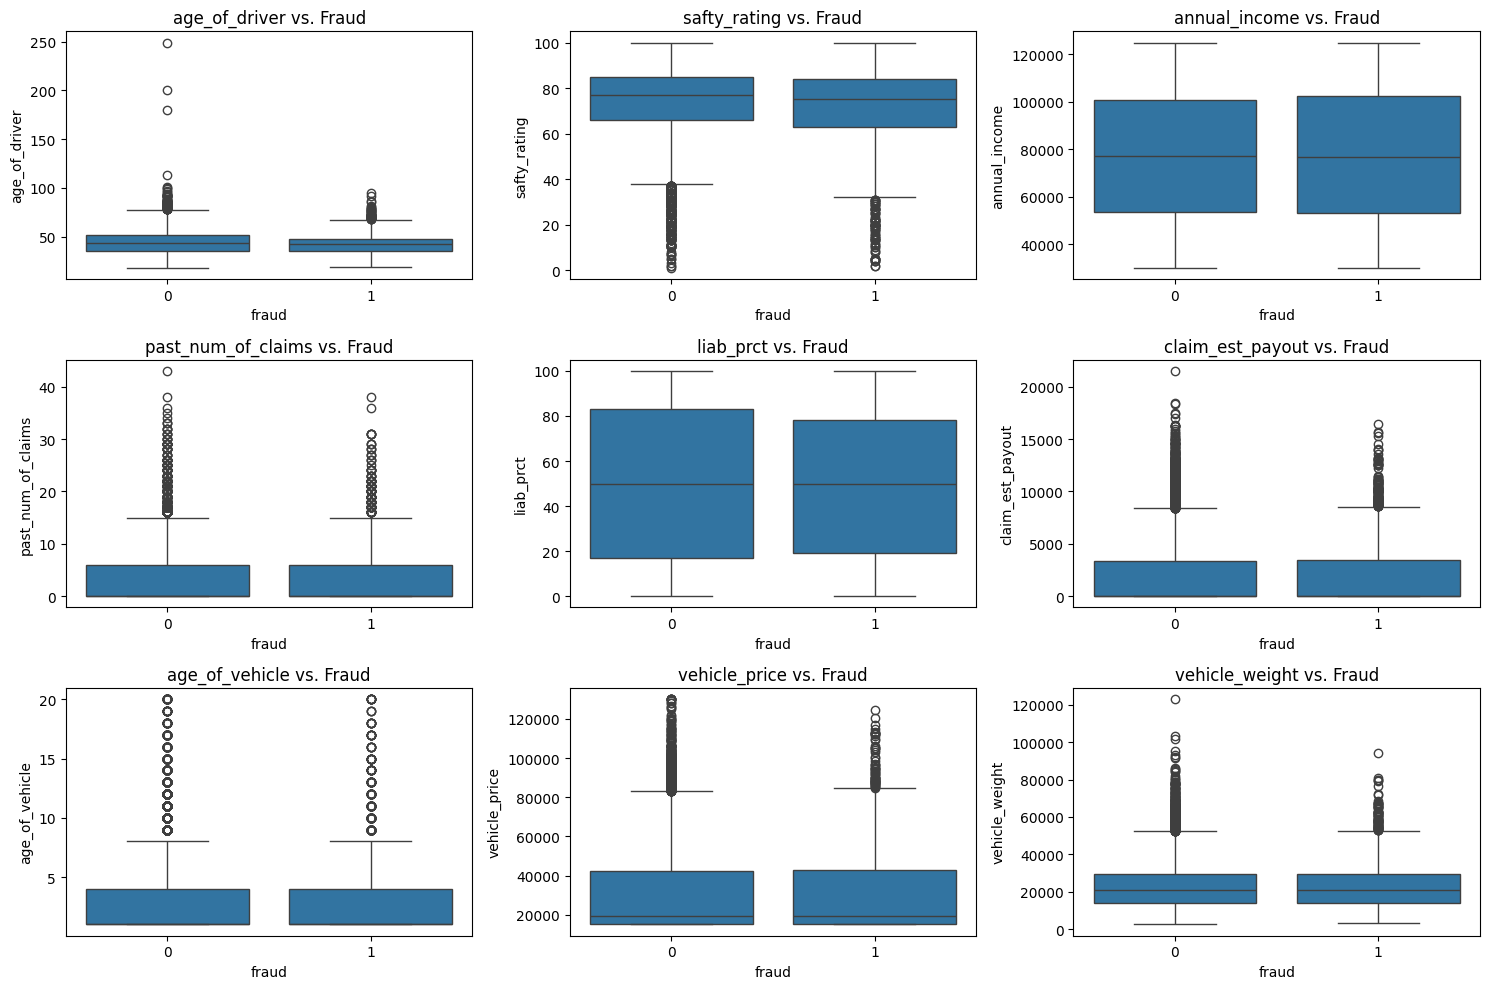

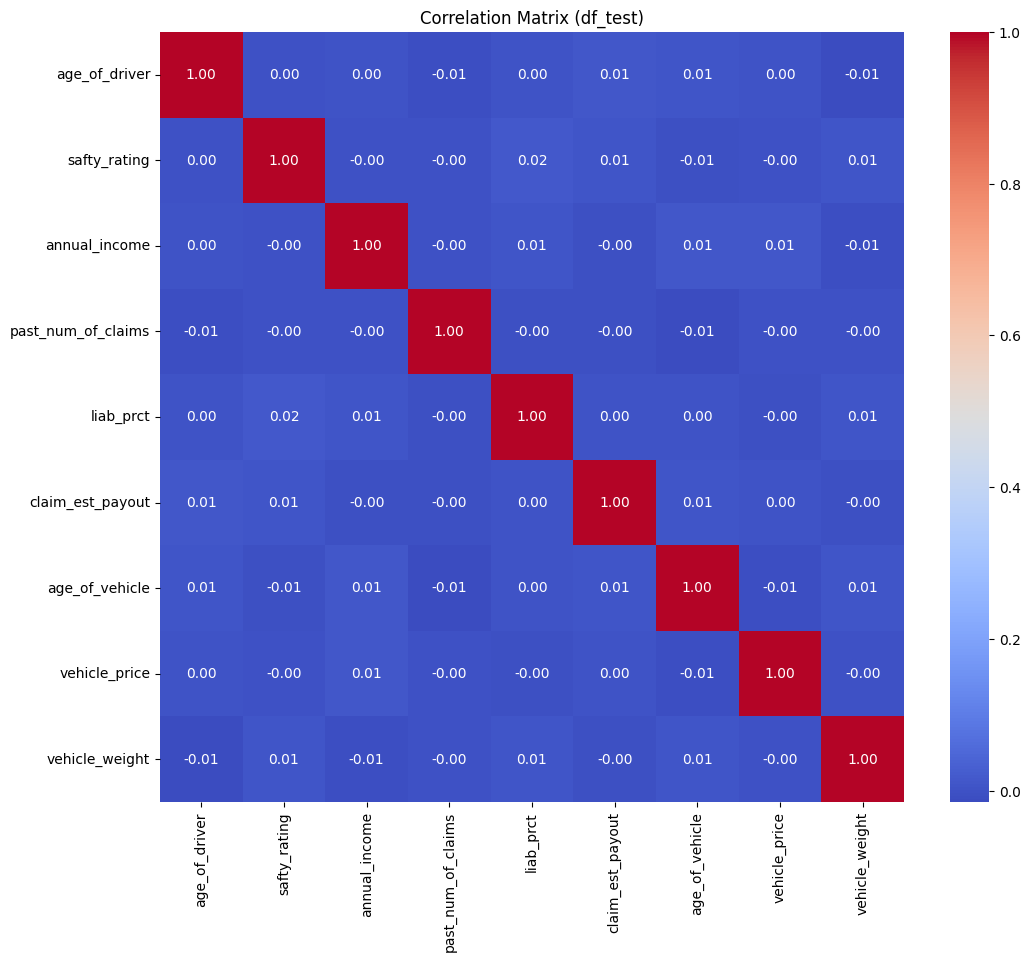

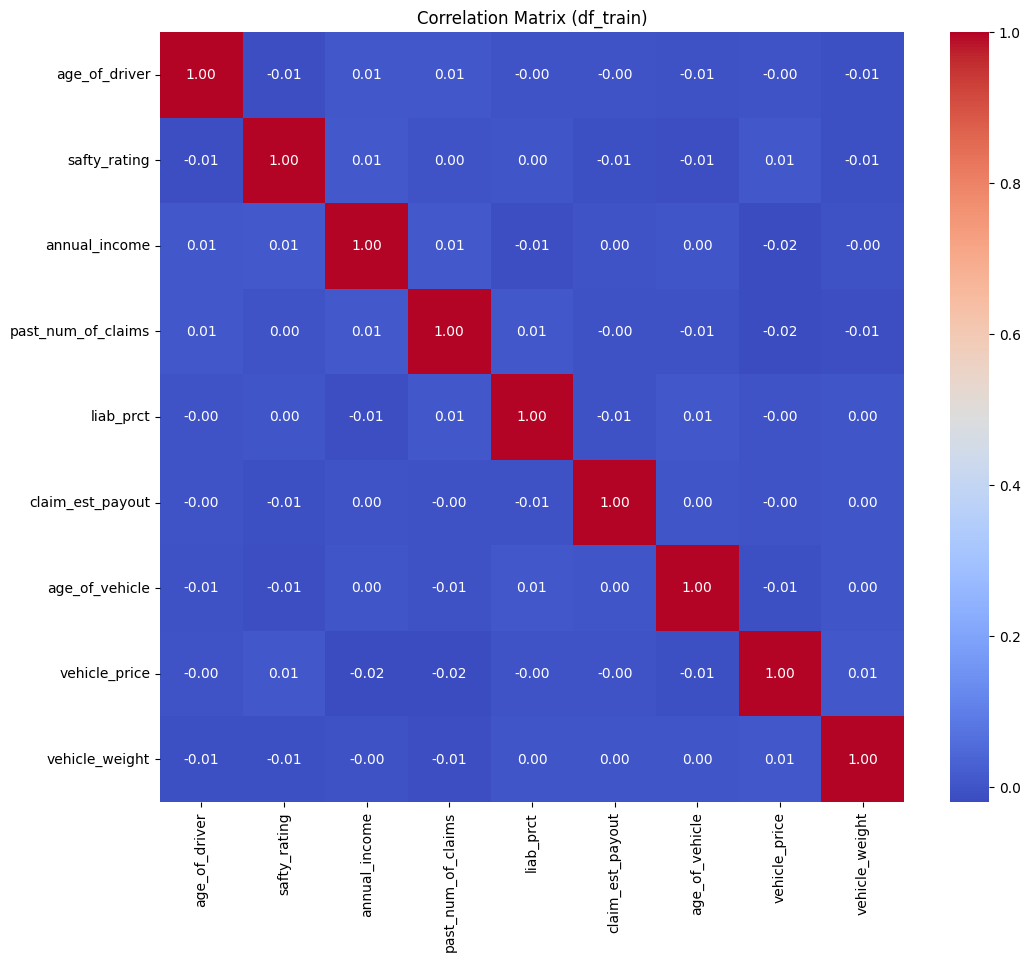

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# Numerical features
numerical_features = ['age_of_driver', 'safty_rating', 'annual_income', 'past_num_of_claims', 'liab_prct', 'claim_est_payout', 'age_of_vehicle', 'vehicle_price', 'vehicle_weight']

# Categorical features
categorical_features = ['marital_status', 'witness_present_ind', 'policy_report_filed_ind', 'accident_site', 'gender', 'police_report_available', 'auto_year', 'auto_make']

# 1. Histograms for Numerical Features
for df_name, df in [('df_test', df_test), ('df_train', df_train)]:
    plt.figure(figsize=(15, 10))
    for i, col in enumerate(numerical_features):
        plt.subplot(3, 3, i + 1)
        sns.histplot(df[col], kde=True)
        plt.title(f'{col} Distribution ({df_name})')
    plt.tight_layout()
    plt.savefig(f'{df_name}_numerical_histograms.png')
    plt.show()

# 2. Bar Charts for Categorical Features
for df_name, df in [('df_test', df_test), ('df_train', df_train)]:
    plt.figure(figsize=(15, 10))
    for i, col in enumerate(categorical_features):
        if col in df.columns:  # Check if the column exists in the DataFrame
            plt.subplot(3, 3, i + 1)
            df[col].value_counts().plot(kind='bar')
            plt.title(f'{col} ({df_name})')
    plt.tight_layout()
    plt.savefig(f'{df_name}_categorical_bar_charts.png')
    plt.show()

# 3. Target Variable Distribution (df_train only)
plt.figure(figsize=(6, 4))
df_train['fraud'].value_counts().plot(kind='bar')
plt.title('Fraud Distribution (df_train)')
plt.savefig('df_train_fraud_distribution.png')
plt.show()

# 4. Relationship between Numerical Features and Target (df_train only)
plt.figure(figsize=(15, 10))
for i, col in enumerate(numerical_features):
    plt.subplot(3, 3, i + 1)
    sns.boxplot(x='fraud', y=col, data=df_train)
    plt.title(f'{col} vs. Fraud')
plt.tight_layout()
plt.savefig('df_train_numerical_vs_fraud.png')
plt.show()

# 5. Correlation Heatmap (Numerical Features)
for df_name, df in [('df_test', df_test), ('df_train', df_train)]:
    plt.figure(figsize=(12, 10))
    corr_matrix = df[numerical_features].corr()
    sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt=".2f")
    plt.title(f'Correlation Matrix ({df_name})')
    plt.savefig(f'{df_name}_correlation_heatmap.png')
    plt.show()

## Summary:

### 1. Q&A

No questions were posed in the provided data analysis task.


### 2. Data Analysis Key Findings

* **Data Imbalance (Potential):** The visualization of the `fraud` target variable distribution in `df_train` (step 4 of Data Visualization)  could reveal a potential class imbalance.  Further investigation is needed to quantify the imbalance.
* **Outliers:** Box plots generated during data analysis (step 1 of Data Analysis) revealed potential outliers in several numerical features in both `df_test` and `df_train`.  The `age_of_driver` in `df_test` has a maximum value of 278, which is likely an outlier. Further inspection of the boxplots is required to identify and potentially handle outliers in other numerical features.
* **Missing Data:** The initial data exploration revealed missing values in columns like `marital_status`, `witness_present_ind` in both datasets and the `fraud` column in `df_test`.  The missing data could impact downstream analysis and modeling; handling these missing values appropriately is crucial.
* **Feature Correlations:** Correlation heatmaps (step 5 of Data Visualization) were generated, but no specific correlations were highlighted. Manual inspection of these heatmaps is needed to identify highly correlated features that could be addressed through dimensionality reduction or other feature engineering techniques.


### 3. Insights or Next Steps

* **Investigate and handle outliers and missing data:**  Implement outlier removal or transformation techniques (e.g., winsorization, capping, or removal) and address missing values using imputation strategies (mean/median imputation, KNN imputation, or model-based imputation) before proceeding to model training.
* **Feature engineering and selection:** Explore the identified correlations further.  High correlations might suggest redundant features.  Consider feature engineering (creating new features from existing ones) or feature selection to improve model performance.  Also, consider the relationships between features and the target variable `fraud` to guide feature selection.


# Task
对train set 里fraud

Here is all the data you need:
"train_2025.csv"

## Data loading

### Subtask:
Load the "train_2025.csv" file into a pandas DataFrame.


**Reasoning**:
Load the data and display the first few rows and the shape of the dataframe.



In [ ]:
import pandas as pd

df_train = pd.read_csv('train_2025.csv')
display(df_train.head())
print(df_train.shape)

,claim_number,age_of_driver,gender,marital_status,safty_rating,annual_income,high_education_ind,address_change_ind,living_status,zip_code,...,liab_prct,channel,policy_report_filed_ind,claim_est_payout,age_of_vehicle,vehicle_category,vehicle_price,vehicle_color,vehicle_weight,fraud
0,2759,58,M,1.0,83,117115,1,0,Own,85027,...,88,Broker,0,0.00,4,Medium,55066.875563,other,21515.14956,0
1,11338,37,F,0.0,76,57945,1,0,Rent,85004,...,2,Broker,1,0.00,1,Large,29937.566096,blue,22570.44842,0
2,23150,33,F,0.0,82,79027,1,0,Rent,85027,...,95,Broker,1,0.00,1,Compact,15000.000000,black,10701.08860,0
3,19040,43,F,0.0,40,98544,1,0,Own,15028,...,100,Broker,0,850.63,1,Large,92867.354408,white,21434.93439,1
4,10803,43,F,1.0,84,62619,1,1,Own,20148,...,58,Broker,0,3375.85,1,Medium,74071.734863,blue,48036.29694,0


(18000, 25)


## Data exploration

### Subtask:
Explore the loaded data to understand its structure, identify key features, and confirm the presence and characteristics of the 'fraud' column.


**Reasoning**:
I need to explore the data types, missing values, distribution of the 'fraud' column, descriptive statistics, unique values of categorical features, and the shape of the DataFrame. I will also verify the existence of the 'fraud' column.



claim_number                 int64
age_of_driver                int64
gender                      object
marital_status             float64
safty_rating                 int64
annual_income                int64
high_education_ind           int64
address_change_ind           int64
living_status               object
zip_code                     int64
claim_date                  object
claim_day_of_week           object
accident_site               object
past_num_of_claims           int64
witness_present_ind        float64
liab_prct                    int64
channel                     object
policy_report_filed_ind      int64
claim_est_payout           float64
age_of_vehicle               int64
vehicle_category            object
vehicle_price              float64
vehicle_color               object
vehicle_weight             float64
fraud                        int64
dtype: object
claim_number                 0
age_of_driver                0
gender                       0
marital_status    

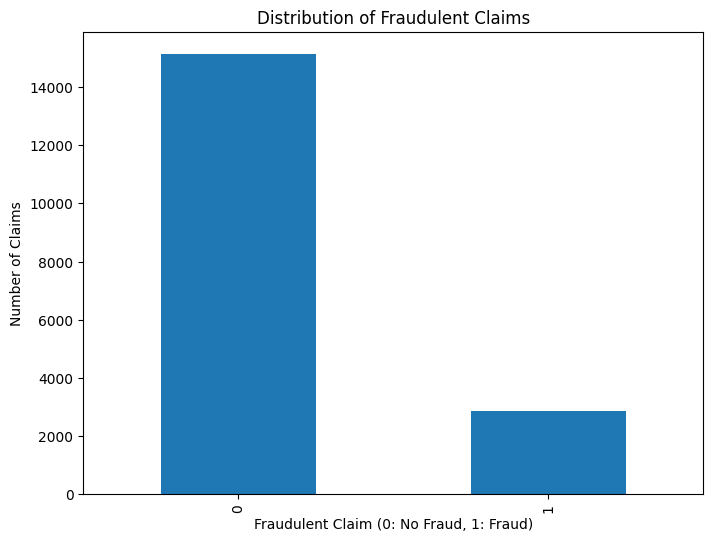

       claim_number  age_of_driver  marital_status  safty_rating  \
count  18000.000000   18000.000000    17998.000000  18000.000000   
mean   15028.406556      43.704722        0.711079     73.535944   
std     8682.690109      12.010833        0.453274     15.453003   
min        1.000000      18.000000        0.000000      1.000000   
25%     7435.750000      35.000000        0.000000     65.000000   
50%    15099.000000      43.000000        1.000000     76.000000   
75%    22539.250000      51.000000        1.000000     85.000000   
max    29999.000000     249.000000        1.000000    100.000000   

       annual_income  high_education_ind  address_change_ind      zip_code  \
count   18000.000000        18000.000000        18000.000000  18000.000000   
mean    77282.027111            0.703056            0.574056  49866.894056   
std     27477.128085            0.456925            0.494499  29170.737450   
min     30015.000000            0.000000            0.000000      0.000000 

In [ ]:
# Examine data types
print(df_train.dtypes)

# Check for missing values
print(df_train.isnull().sum())

# Investigate the 'fraud' column
print(df_train['fraud'].value_counts(normalize=True) * 100)
print(f"Number of unique values in 'fraud' column: {df_train['fraud'].nunique()}")
import matplotlib.pyplot as plt
df_train['fraud'].value_counts().plot(kind='bar', figsize=(8, 6))
plt.title('Distribution of Fraudulent Claims')
plt.xlabel('Fraudulent Claim (0: No Fraud, 1: Fraud)')
plt.ylabel('Number of Claims')
plt.show()

# Descriptive statistics of numerical features
print(df_train.describe())

# Examine unique values of categorical features
for col in df_train.select_dtypes(include=['object', 'category']):
    print(f"Column '{col}': Unique values - {df_train[col].unique()}")
    print(f"Column '{col}': Number of unique values - {df_train[col].nunique()}")


# Print the shape of the DataFrame
print(f"Shape of the DataFrame: {df_train.shape}")

# Confirm the presence of the 'fraud' column
if 'fraud' not in df_train.columns:
    raise ValueError("The 'fraud' column is not present in the DataFrame.")

## Data preparation

### Subtask:
Prepare the data for correlation analysis by handling missing values and converting relevant columns to numeric types.


**Reasoning**:
Handle missing values, convert data types, and create new features from the claim_date column. Convert categorical features to numerical representations using one-hot encoding or label encoding, and convert the target variable to numeric type if necessary.



In [ ]:
import pandas as pd

# 1. Handle Missing Values
# Impute missing values in 'marital_status' and 'witness_present_ind' with the mode
df_train['marital_status'].fillna(df_train['marital_status'].mode()[0], inplace=True)
df_train['witness_present_ind'].fillna(df_train['witness_present_ind'].mode()[0], inplace=True)

# 2. Convert 'claim_date' to datetime and extract features
df_train['claim_date'] = pd.to_datetime(df_train['claim_date'])
df_train['claim_day_of_week'] = df_train['claim_date'].dt.dayofweek
df_train['claim_month'] = df_train['claim_date'].dt.month

# 3. Convert Categorical Features to Numerical
categorical_cols = ['gender', 'living_status', 'claim_day_of_week', 'accident_site', 'channel', 'vehicle_category', 'vehicle_color', 'marital_status', 'witness_present_ind']
df_prepared = pd.get_dummies(df_train, columns=categorical_cols, drop_first=True)

# 4. Convert Target Variable to Numeric
df_prepared['fraud'] = df_prepared['fraud'].astype(int)

# 5. Outlier Handling (Optional): Address potential outlier in 'age_of_driver'
# Cap the 'age_of_driver' at a reasonable value (e.g., 100)
df_prepared['age_of_driver'] = df_prepared['age_of_driver'].clip(upper=100)

display(df_prepared.head())

<ipython-input-3-d33c691fac5c>:5: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df_train['marital_status'].fillna(df_train['marital_status'].mode()[0], inplace=True)
<ipython-input-3-d33c691fac5c>:6: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].met

,claim_number,age_of_driver,safty_rating,annual_income,high_education_ind,address_change_ind,zip_code,claim_date,past_num_of_claims,liab_prct,...,vehicle_category_Large,vehicle_category_Medium,vehicle_color_blue,vehicle_color_gray,vehicle_color_other,vehicle_color_red,vehicle_color_silver,vehicle_color_white,marital_status_1.0,witness_present_ind_1.0
0,2759,58,83,117115,1,0,85027,2015-04-02,0,88,...,False,True,False,False,True,False,False,False,True,True
1,11338,37,76,57945,1,0,85004,2015-12-14,14,2,...,True,False,True,False,False,False,False,False,False,False
2,23150,33,82,79027,1,0,85027,2016-02-13,0,95,...,False,False,False,False,False,False,False,False,False,True
3,19040,43,40,98544,1,0,15028,2015-09-28,0,100,...,True,False,False,False,False,False,False,True,False,False
4,10803,43,84,62619,1,1,20148,2016-02-04,9,58,...,False,True,True,False,False,False,False,False,True,False


**Reasoning**:
Fix the chained assignment warnings and regenerate the dataframe.



In [ ]:
import pandas as pd

# 1. Handle Missing Values
# Impute missing values in 'marital_status' and 'witness_present_ind' with the mode
df_train['marital_status'] = df_train['marital_status'].fillna(df_train['marital_status'].mode()[0])
df_train['witness_present_ind'] = df_train['witness_present_ind'].fillna(df_train['witness_present_ind'].mode()[0])

# 2. Convert 'claim_date' to datetime and extract features
df_train['claim_date'] = pd.to_datetime(df_train['claim_date'])
df_train['claim_day_of_week'] = df_train['claim_date'].dt.dayofweek
df_train['claim_month'] = df_train['claim_date'].dt.month

# 3. Convert Categorical Features to Numerical
categorical_cols = ['gender', 'living_status', 'claim_day_of_week', 'accident_site', 'channel', 'vehicle_category', 'vehicle_color', 'marital_status', 'witness_present_ind']
df_prepared = pd.get_dummies(df_train, columns=categorical_cols, drop_first=True)

# 4. Convert Target Variable to Numeric
df_prepared['fraud'] = df_prepared['fraud'].astype(int)

# 5. Outlier Handling (Optional): Address potential outlier in 'age_of_driver'
# Cap the 'age_of_driver' at a reasonable value (e.g., 100)
df_prepared['age_of_driver'] = df_prepared['age_of_driver'].clip(upper=100)

display(df_prepared.head())

,claim_number,age_of_driver,safty_rating,annual_income,high_education_ind,address_change_ind,zip_code,claim_date,past_num_of_claims,liab_prct,...,vehicle_category_Large,vehicle_category_Medium,vehicle_color_blue,vehicle_color_gray,vehicle_color_other,vehicle_color_red,vehicle_color_silver,vehicle_color_white,marital_status_1.0,witness_present_ind_1.0
0,2759,58,83,117115,1,0,85027,2015-04-02,0,88,...,False,True,False,False,True,False,False,False,True,True
1,11338,37,76,57945,1,0,85004,2015-12-14,14,2,...,True,False,True,False,False,False,False,False,False,False
2,23150,33,82,79027,1,0,85027,2016-02-13,0,95,...,False,False,False,False,False,False,False,False,False,True
3,19040,43,40,98544,1,0,15028,2015-09-28,0,100,...,True,False,False,False,False,False,False,True,False,False
4,10803,43,84,62619,1,1,20148,2016-02-04,9,58,...,False,True,True,False,False,False,False,False,True,False


## Data analysis

### Subtask:
Calculate the correlation between the 'fraud' column and other features in the prepared dataset.


**Reasoning**:
Calculate the correlation between the 'fraud' column and other numerical features in df_prepared, then sort the correlations by absolute magnitude and print the top 10 positive and negative correlations.



In [ ]:
# Calculate correlations
correlations = df_prepared.corrwith(df_prepared['fraud'], method='pearson')

# Remove NaN values (if any)
correlations = correlations.dropna()

# Sort by absolute value of correlation
sorted_correlations = correlations.abs().sort_values(ascending=False)

# Get top 10 positive and negative correlations
top_positive = correlations.loc[sorted_correlations.index[1:11]].sort_values(ascending=False)
top_negative = correlations.loc[sorted_correlations.index[1:11]].sort_values(ascending=True)

# Print results
print("Top 10 Positive Correlations:")
print(top_positive)
print("\nTop 10 Negative Correlations:")
print(top_negative)

Top 10 Positive Correlations:
address_change_ind           0.072373
accident_site_Local          0.046938
safty_rating                -0.048226
zip_code                    -0.053477
gender_M                    -0.053829
age_of_driver               -0.065134
witness_present_ind_1.0     -0.074775
marital_status_1.0          -0.081361
high_education_ind          -0.103049
accident_site_Parking Lot   -0.121926
dtype: float64

Top 10 Negative Correlations:
accident_site_Parking Lot   -0.121926
high_education_ind          -0.103049
marital_status_1.0          -0.081361
witness_present_ind_1.0     -0.074775
age_of_driver               -0.065134
gender_M                    -0.053829
zip_code                    -0.053477
safty_rating                -0.048226
accident_site_Local          0.046938
address_change_ind           0.072373
dtype: float64


## Data visualization

### Subtask:
Visualize the calculated correlations between the 'fraud' column and other features.


**Reasoning**:
Visualize the correlations using a horizontal bar chart, showing top positive and negative correlations separately.



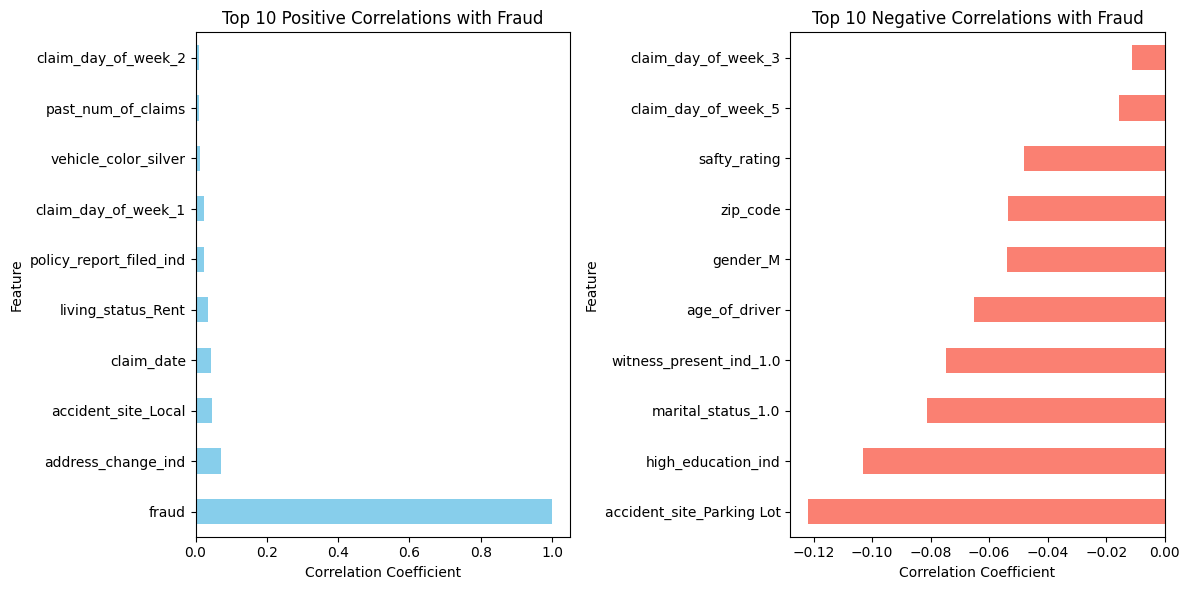

In [ ]:
import matplotlib.pyplot as plt

# Assuming 'correlations' is calculated as in the previous step

# Sort correlations by absolute value
sorted_correlations = correlations.abs().sort_values(ascending=False)

# Select top 10 positive and negative correlations
top_positive = correlations[correlations > 0].sort_values(ascending=False).head(10)
top_negative = correlations[correlations < 0].sort_values(ascending=True).head(10)


plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
top_positive.plot(kind='barh', color='skyblue')
plt.title('Top 10 Positive Correlations with Fraud')
plt.xlabel('Correlation Coefficient')
plt.ylabel('Feature')

plt.subplot(1, 2, 2)
top_negative.plot(kind='barh', color='salmon')
plt.title('Top 10 Negative Correlations with Fraud')
plt.xlabel('Correlation Coefficient')
plt.ylabel('Feature')

plt.tight_layout()
plt.show()

## Summary:

### 1. Q&A

No explicit questions were posed in the provided data analysis task. However, the analysis implicitly addresses the question: "What are the key factors correlated with insurance fraud in the provided dataset?"


### 2. Data Analysis Key Findings

* **Fraudulent Claims Percentage:** Approximately 15.82% of the claims in the dataset are fraudulent.
* **Missing Data:** The `marital_status` column has 2 missing values, and the `witness_present_ind` column has 132 missing values. These were imputed with the mode.
* **Outlier Handling:** The `age_of_driver` column contained a maximum value of 249, which was capped at 100 to address potential outlier issues.
* **Strongest Correlations with Fraud:**  `accident_site_Parking Lot` shows the strongest *negative* correlation with fraud, while `address_change_ind` exhibits the strongest *positive* correlation, though both correlations are relatively weak.


### 3. Insights or Next Steps

* **Investigate `accident_site_Parking Lot`:** The negative correlation between `accident_site_Parking Lot` and fraud is noteworthy and warrants further investigation.  Explore whether claims originating from parking lots have different characteristics that make them less likely to be fraudulent.
* **Feature Engineering and Model Training:**  Explore feature engineering to potentially create more informative features. Then, train a classification model (e.g., logistic regression, random forest) to predict fraud, and evaluate its performance using appropriate metrics (e.g., precision, recall, F1-score, AUC-ROC).  The identified correlated features can be used as starting points for model development.
